In [116]:
import folium
import pandas as pd
import geopandas as gpd

In [20]:
villuco = pd.read_csv('villuco_random_points.csv',usecols=[1,3], header=None, names=['La', 'Lo'])

In [21]:
villuco.shape

(600, 2)

In [22]:
villuco.head()

,La,Lo
0,-36.879394,-73.034098
1,-36.880376,-73.036537
2,-36.884357,-73.040233
3,-36.871128,-73.038928
4,-36.876888,-73.032951


In [117]:
villuco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
La    600 non-null float64
Lo    600 non-null float64
dtypes: float64(2)
memory usage: 9.5 KB


In [25]:
import folium
import folium.plugins

COORDINATES = [-36.8774383, -73.03479970000001]

m = folium.Map(location=COORDINATES, zoom_start=20)
marker_cluster = folium.plugins.MarkerCluster().add_to(m)

# folium.Marker([45.3288, -121.6625], popup='<i>Mt. Hood Meadows</i>').add_to(m)

lat = villuco['La'].tolist()
long = villuco['Lo'].tolist()
coords = zip(lat,long)

for coord in zip(lat,long):
    folium.Marker([coord[0], coord[1]]).add_to(marker_cluster)
m

In [133]:
# from shapely.geometry import Point, Polygon
# import geopandas

polys = geopandas.GeoSeries({
    'foo': Polygon([(5, 5), (5, 13), (13, 13), (13, 5)]),
    'bar': Polygon([(10, 10), (10, 15), (15, 15), (15, 10)]),
})

print(polys)
_pnts = [Point(3, 3), Point(8, 8), Point(11, 11)]
pnts = geopandas.GeoDataFrame(geometry=_pnts, index=['A', 'B', 'C'])
pnts = pnts.assign(**{key: pnts.within(geom) for key, geom in polys.items()})

print(pnts)

foo          POLYGON ((5 5, 5 13, 13 13, 13 5, 5 5))
bar    POLYGON ((10 10, 10 15, 15 15, 15 10, 10 10))
dtype: object
        geometry    foo    bar
A    POINT (3 3)  False  False
B    POINT (8 8)   True  False
C  POINT (11 11)   True   True


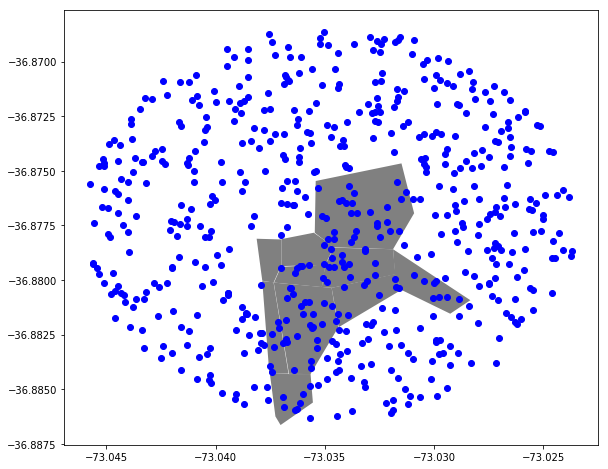

In [126]:
from shapely.geometry import Point, Polygon
import geopandas

polys = geopandas.read_file('villuco.geojson')
polys.reset_index(inplace=True)
# polys = polys.geometry

points = []
for coord in zip(lat,long):
    points.append(Point(coord[1], coord[0]))

pnts = geopandas.GeoDataFrame(geometry=points)

f, ax = plt.subplots(figsize=(12,8))
polys.plot(ax=ax, color='gray')
pnts.plot(ax=ax, color='blue')

plt.show()


In [127]:
polys

,index,geometry
0,0,POLYGON ((-73.03786039352417 -36.8800325387795...
1,1,POLYGON ((-73.03732395172119 -36.8801183580316...
2,2,POLYGON ((-73.03698062896729 -36.8781273265461...
3,3,POLYGON ((-73.03786039352417 -36.8800497026376...
4,4,POLYGON ((-73.03457736968994 -36.8785221041561...
5,5,POLYGON ((-73.03436279296875 -36.8821608277704...
6,6,POLYGON ((-73.03187370300293 -36.8785907609234...
7,7,POLYGON ((-73.03702354431152 -36.8866403389975...
8,8,POLYGON ((-73.03545713424683 -36.8778355330880...
9,9,POLYGON ((-73.03733468055725 -36.8801183580316...


In [128]:
pnts

,geometry
0,POINT (-73.03409766999999 -36.87939411)
1,POINT (-73.03653706999999 -36.88037621)
2,POINT (-73.04023303 -36.88435689)
3,POINT (-73.03892802999999 -36.8711276)
4,POINT (-73.03295056 -36.87688795)
5,POINT (-73.02823352999999 -36.87094085)
6,POINT (-73.03011825999999 -36.88453538)
7,POINT (-73.03235823999999 -36.88126729)
8,POINT (-73.02757624 -36.87719899)
9,POINT (-73.04163971 -36.87093914)


In [134]:
import shapely.speedups
shapely.speedups.enable()

s = pnts.within(polys.loc[0,'geometry'])
s[ s == True]

TypeError: cannot do label indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [0] of <class 'int'>

In [97]:
# state_geo = os.path.join('data', 'us-states.json')
SF_COORDINATES = (37.76, -122.45)
crimedata = pd.read_csv('sfpd_incidents.csv')

m2 = folium.Map(location=COORDINATES, zoom_start=16)
district_geo = r'villuco.geojson'

crimedata['1'] = 1
crimedata2 = crimedata.groupby('Police District').sum()
# crimedata2

district_geo.index

crimedata2.reset_index(inplace=True)
# crimedata2.columns = ['District', 'Number']

cd = crimedata2[['Police District', '1']]
cd.columns = ['district', '1']
cd.district = cd.district.str.upper()

m2.choropleth(
    geo_data=district_geo,
    name='choropleth',
    data=cd,
    columns=['district', '1'],
    key_on='feature.properties.district',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of incidents per district'
)

marker_cluster = folium.plugins.MarkerCluster().add_to(m2)

# folium.Marker([45.3288, -121.6625], popup='<i>Mt. Hood Meadows</i>').add_to(m)

lat = villuco['La'].tolist()
long = villuco['Lo'].tolist()
coords = zip(lat,long)

for coord in zip(lat,long):
    folium.Marker([coord[0], coord[1]]).add_to(marker_cluster)

folium.LayerControl().add_to(m2)

m2

C:\Users\joaquin\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
